# Wine Quality Analysis
Yamika Gandhi (43717539)

## Importing Libraries

In [1]:
import pandas as pd #Library to handle dataframes
import matplotlib.pyplot as plt # Library to plot graphics
import matplotlib.ticker as ticker #to format plot axes labels
import numpy as np # To work with matrices
import statistics
from scipy.stats import ttest_ind #to perform t-test for feature selection
from sklearn.linear_model import LogisticRegression #to fit logistic regression model
from sklearn.metrics import confusion_matrix #to assess model performance

## Importing the Dataset 

In [2]:
filename = "winequality-white.csv" #white wine dataset
dataframe = pd.read_csv(filename, header=0, delimiter=';')
dataframe.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
5,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
6,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6
7,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
8,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
9,8.1,0.22,0.43,1.5,0.044,28.0,129.0,0.9938,3.22,0.45,11.0,6


In [3]:
rows, columns = dataframe.shape 
print(f"Rows: {rows}")
print(f"Columns: {columns}")

print(f"Across {rows} observations, we have {columns} columns in total.")

Rows: 4898
Columns: 12
Across 4898 observations, we have 12 columns in total.


Out of these, we have 11 predictors, and 1 predicted variable ("quality").

Setting aside 100 random observations to form the test dataset-

In [4]:
np.random.seed(42)
total_observations = len(dataframe)

# Generate random indices for the test set
test_indices = np.random.choice(total_observations, size=100, replace=False)

# Create the test set by selecting the rows with the random indices
test_set = dataframe.iloc[test_indices]

# Create the training set by excluding the rows with the random indices
train_set = dataframe.drop(test_indices)

## Exploratory Data Analysis

Checking for duplicate values:

In [5]:
duplicates = train_set.duplicated()
num_duplicates = duplicates.sum()
print("Number of Duplicate Rows:", num_duplicates)
print("Number of Unique Rows:", rows - 100 - num_duplicates)

Number of Duplicate Rows: 895
Number of Unique Rows: 3903


We are going to drop the duplicate rows from the dataset for a more accurate analysis:

In [6]:
df = train_set.drop_duplicates()

We are going to create a summary table called 'summary' for the wine dataset. This allows us to look at all the columns / explanatory variables / predictors one by one.
We look at the data types in each column, the number of missing values, and the number of unique values.

In [7]:
summary = pd.DataFrame()
summary['Data type'] = df.dtypes
summary['Missing'] = df.isna().sum().values 
summary['Uniques'] = df.nunique().values
print(summary)

                     Data type  Missing  Uniques
fixed acidity          float64        0       68
volatile acidity       float64        0      125
citric acid            float64        0       86
residual sugar         float64        0      309
chlorides              float64        0      158
free sulfur dioxide    float64        0      132
total sulfur dioxide   float64        0      251
density                float64        0      889
pH                     float64        0      103
sulphates              float64        0       79
alcohol                float64        0      103
quality                  int64        0        7


We can see that the explained variable ("quality") is discrete (int) and not continuous-valued. The corresponding domain is {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}, i.e., a score indicating the quality of wine.

The explanatory variables / predictors are all continuous-valued (float) and are related to the physio-chemical properties of the wine. 



Looking at the summary statistics of all the predictors:

In [8]:
summary_stats = df.describe()
summary_stats

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000
mean,6.839085,0.280552,0.333900,5.911606,0.045783,34.909044,137.165898,0.993786,3.195555,0.490569,10.591531,5.852677
std,0.867531,0.103363,0.122083,4.859073,0.022806,17.237422,43.078904,0.002909,0.151851,0.113692,1.217337,0.889066
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.600000,0.035000,23.000000,106.000000,0.991600,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,4.700000,0.042000,33.000000,133.000000,0.993480,3.180000,0.480000,10.400000,6.000000
75%,7.300000,0.330000,0.390000,8.850000,0.050000,45.000000,166.000000,0.995705,3.290000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


### Explained Variable - "quality"

Looking at the distribution of the explained variable, "quality":

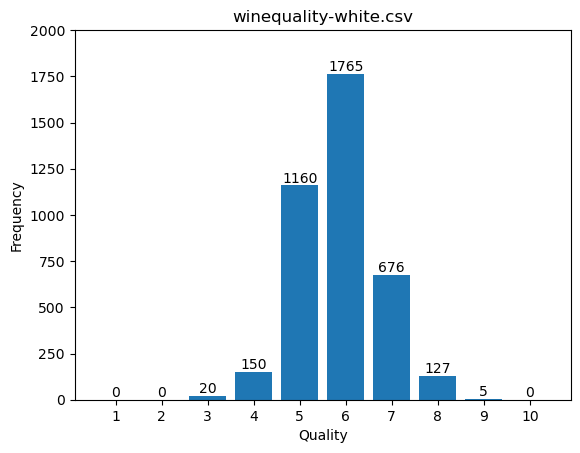

In [9]:
axes = plt.axes()


scores = [1,2,3,4,5,6,7,8,9,10]

frequencies = dict()

for score in scores:
    count = df['quality'].value_counts().get(score, 0)
    frequencies[score] = count

axes.set_ylim(0, 2000)    
xticks = range(0,11)
axes.set_xticks(xticks)
axes.set_xticklabels(xticks)
axes.set_xlabel('Quality')
axes.set_ylabel('Frequency')
axes.set_title(filename)


bars = axes.bar(frequencies.keys(), frequencies.values())
plt.bar_label(bars)

plt.show()


There are no wines with quality value 1, 2 or 10.
Most of the wines have quality value 5 or 6.
The distribution appears to be approximately normal, with Mean = 5.85 and Median = 6.


To convert 'quality' into a binary categorical variable, we can use the fact that the mean is 5.85. Any wine qith a quality score lower than or equal to 5 can be categorized as class 0 or 'bad' wine; and any wine with quality score higher than 5 can be categorized as class 1 or 'good' wine.
We add another column to the dataframe called 'class' and store the correct class in it.

In [10]:
mean_value = summary_stats.loc['mean', 'quality']
print("Mean:", mean_value)

wine_class = []
quality = df['quality']
for q in quality:
    if q>mean_value:
        wine_class.append(1)
    else:
        wine_class.append(0)

df.loc[:, 'class'] = wine_class
df


Mean: 5.8526774276197795


/var/folders/61/5gjx4xb906zf4wq9cntygmr80000gn/T/ipykernel_68306/608493387.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'class'] = wine_class


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,class
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,1
6,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.99490,3.18,0.47,9.6,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,1
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,0
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,1
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,1


Looking at the distribution of the categorical variable 'class':

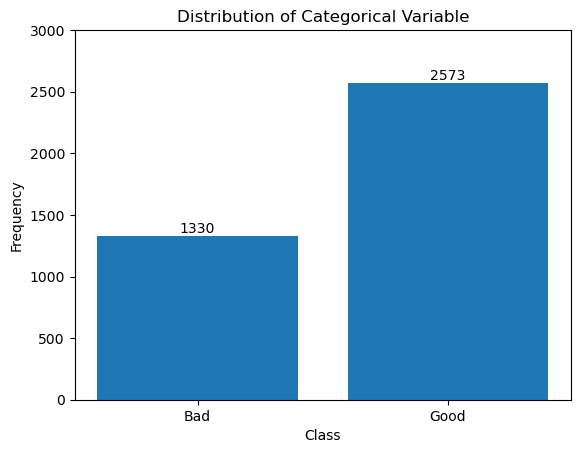

In [11]:
axes = plt.axes()


categories = [0,1]

frequencies2 = dict()

for category in categories:
    count = df['class'].value_counts()[category]
    frequencies2[category] = count
    
labels = ['Bad', 'Good']

axes.set_ylim(0, 3000)    
axes.set_xticks(range(len(labels)))
axes.set_xticklabels(labels)
axes.set_xlabel('Class')
axes.set_ylabel('Frequency')
axes.set_title('Distribution of Categorical Variable')


bars = axes.bar(frequencies2.keys(), frequencies2.values())
plt.bar_label(bars)

plt.show()


## Data Cleaning: Outlier Detection & Removal

We will look at each of the predictors / explanatory variables to see if there are any outliers, and remove them. Removing outliers can help provide a more accurate representation of the underlying data distribution and improve the validity of our statistical inferences.

We can set a threshold at 5 standard deviations away from the mean. Any data point beyond this threshold (either above the upper bound or below the lower bound) can be treated as an outlier and can be removed. This threshold removes data points that deviate significantly from the majority of the data, which means it removes a relatively small number of data points.

We do this for each of the 11 predictors-

Mean: 6.839, Std. dev: 0.867
Outlier Values:
1526    14.2
2050    11.8
Name: fixed acidity, dtype: float64
No. of outliers: 2


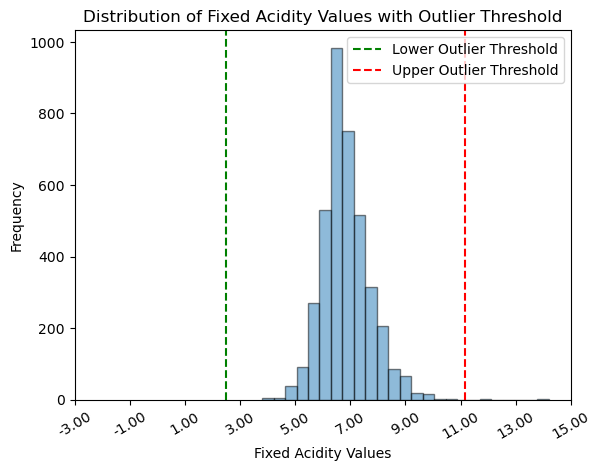

In [12]:
fixed_acidity = df['fixed acidity']

# Calculate statistical measures for the column
mean_fixed_acidity = np.mean(fixed_acidity)
std_fixed_acidity = np.std(fixed_acidity)
print (f"Mean: {mean_fixed_acidity:.3f}, Std. dev: {std_fixed_acidity:.3f}")


# Define a threshold as a multiple of standard deviation (adjust as needed)
threshold = 5


# Identify outliers
outliers_fixed_acidity = fixed_acidity[(fixed_acidity - mean_fixed_acidity).abs() > threshold * std_fixed_acidity]
print(f'Outlier Values:\n{outliers_fixed_acidity}')
print(f'No. of outliers: {len(outliers_fixed_acidity)}')



# Plot the histogram of sulphates
axes = plt.axes()
plt.hist(fixed_acidity, bins=25, edgecolor='black', alpha=0.5)
plt.xlabel('Fixed Acidity Values')
plt.ylabel('Frequency')
xticks = np.arange(int(mean_fixed_acidity - threshold * std_fixed_acidity) - 5, int(mean_fixed_acidity + threshold * std_fixed_acidity) + 5, 2)
axes.set_xticks(xticks)
axes.set_xticklabels(xticks)
axes.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.2f}'))
axes.tick_params(axis='x', rotation=30)
plt.title('Distribution of Fixed Acidity Values with Outlier Threshold')


# Add a line to indicate the threshold for outliers
plt.axvline(x=mean_fixed_acidity - threshold * std_fixed_acidity, color='green', linestyle='--', label='Lower Outlier Threshold')
plt.axvline(x=mean_fixed_acidity + threshold * std_fixed_acidity, color='red', linestyle='--', label='Upper Outlier Threshold')
plt.legend()

plt.show()


Mean: 0.281, Std. dev: 0.103
Outlier Values:
372     0.905
1476    0.850
1856    0.910
1951    1.005
2154    0.930
2417    0.815
2781    0.965
4039    1.100
Name: volatile acidity, dtype: float64
No. of outliers: 8


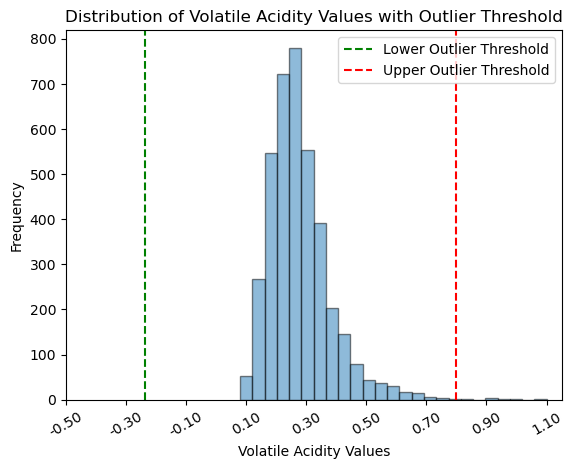

In [13]:
volatile_acidity = df['volatile acidity']

#Calculate statistical measures for the column
mean_volatile_acidity = np.mean(volatile_acidity)
std_volatile_acidity = np.std(volatile_acidity)
print(f"Mean: {mean_volatile_acidity:.3f}, Std. dev: {std_volatile_acidity:.3f}")

#Define a threshold as a multiple of standard deviation (adjust as needed)
threshold = 5

#Identify outliers
outliers_volatile_acidity = volatile_acidity[(volatile_acidity - mean_volatile_acidity).abs() > threshold * std_volatile_acidity]
print(f'Outlier Values:\n{outliers_volatile_acidity}')
print(f'No. of outliers: {len(outliers_volatile_acidity)}')

#Plot the histogram of volatile acidity
axes = plt.axes()
plt.hist(volatile_acidity, bins=25, edgecolor='black', alpha=0.5)
plt.xlabel('Volatile Acidity Values')
plt.ylabel('Frequency')
xticks = np.arange(int(mean_volatile_acidity - threshold * std_volatile_acidity) - 0.5, mean_volatile_acidity + threshold * std_volatile_acidity + 0.5, 0.2)
axes.set_xticks(xticks)
axes.set_xticklabels(xticks)
axes.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.2f}'))
axes.tick_params(axis='x', rotation=30)
plt.title('Distribution of Volatile Acidity Values with Outlier Threshold')

#Add a line to indicate the threshold for outliers
plt.axvline(x=mean_volatile_acidity - threshold * std_volatile_acidity, color='green', linestyle='--', label='Lower Outlier Threshold')
plt.axvline(x=mean_volatile_acidity + threshold * std_volatile_acidity, color='red', linestyle='--', label='Upper Outlier Threshold')
plt.legend()

plt.show()


Mean: 0.334, Std. dev: 0.122
Outlier Values:
745     1.66
946     1.00
1551    0.99
1722    1.00
1775    1.00
3043    1.00
3152    1.23
3497    1.00
Name: citric acid, dtype: float64
No. of outliers: 8


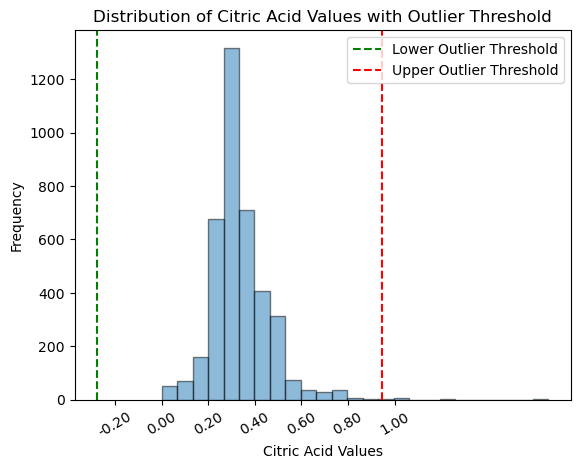

In [14]:
citric_acid = df['citric acid']

# Calculate statistical measures for the column
mean_citric_acid = np.mean(citric_acid)
std_citric_acid = np.std(citric_acid)
print (f"Mean: {mean_citric_acid:.3f}, Std. dev: {std_citric_acid:.3f}")


# Define a threshold as a multiple of standard deviation (adjust as needed)
threshold = 5


# Identify outliers
outliers_citric_acid = citric_acid[(citric_acid - mean_citric_acid).abs() > threshold * std_citric_acid]
print(f'Outlier Values:\n{outliers_citric_acid}')
print(f'No. of outliers: {len(outliers_citric_acid)}')



# Plot the histogram of citric acid
axes = plt.axes()
plt.hist(citric_acid, bins=25, edgecolor='black', alpha=0.5)
plt.xlabel('Citric Acid Values')
plt.ylabel('Frequency')
xticks = np.arange(int((mean_citric_acid)-threshold*std_citric_acid) - 0.2, mean_citric_acid+threshold*std_citric_acid +0.2, 0.2)
axes.set_xticks(xticks)
axes.set_xticklabels(xticks)
axes.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.2f}'))
axes.tick_params(axis='x', rotation=30)
plt.title('Distribution of Citric Acid Values with Outlier Threshold')


# Add a line to indicate the threshold for outliers
plt.axvline(x=mean_citric_acid-threshold*std_citric_acid, color='green', linestyle='--', label='Lower Outlier Threshold')
plt.axvline(x=mean_citric_acid+threshold*std_citric_acid, color='red', linestyle='--', label='Upper Outlier Threshold')
plt.legend()


plt.show()


Mean: 5.912, Std. dev: 4.858
Outlier Values:
1653    31.6
2781    65.8
Name: residual sugar, dtype: float64
No. of outliers: 2


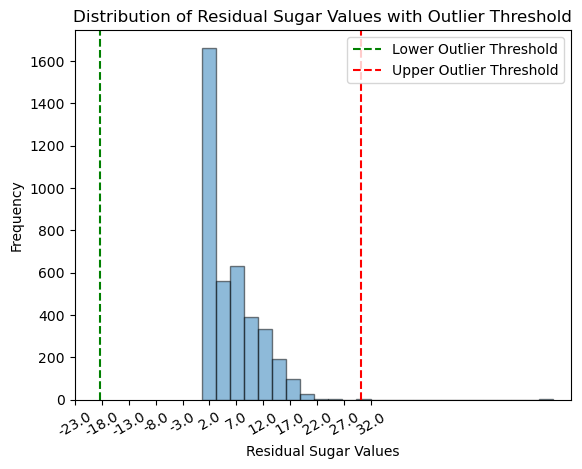

In [15]:
residual_sugar = df['residual sugar']

#Calculate statistical measures for the column
mean_residual_sugar = np.mean(residual_sugar)
std_residual_sugar = np.std(residual_sugar)
print(f"Mean: {mean_residual_sugar:.3f}, Std. dev: {std_residual_sugar:.3f}")

#Define a threshold as a multiple of standard deviation (adjust as needed)
threshold = 5

#Identify outliers
outliers_residual_sugar = residual_sugar[(residual_sugar - mean_residual_sugar) > threshold * std_residual_sugar]
print(f'Outlier Values:\n{outliers_residual_sugar}')
print(f'No. of outliers: {len(outliers_residual_sugar)}')

#Plot the histogram of residual sugar
axes = plt.axes()
plt.hist(residual_sugar, bins=25, edgecolor='black', alpha=0.5)
plt.xlabel('Residual Sugar Values')
plt.ylabel('Frequency')
xticks = np.arange(int(mean_residual_sugar - threshold * std_residual_sugar) - 5, int(mean_residual_sugar + threshold * std_residual_sugar) + 5, 5)
axes.set_xticks(xticks)
axes.set_xticklabels(xticks)
axes.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.1f}'))
axes.tick_params(axis='x', rotation=30)
plt.title('Distribution of Residual Sugar Values with Outlier Threshold')

#Add a line to indicate the threshold for outliers
plt.axvline(x=mean_residual_sugar - threshold * std_residual_sugar, color='green', linestyle='--', label='Lower Outlier Threshold')
plt.axvline(x=mean_residual_sugar + threshold * std_residual_sugar, color='red', linestyle='--', label='Upper Outlier Threshold')
plt.legend()

plt.show()

Mean: 0.046, Std. dev: 0.023
Outlier Values:
484     0.346
683     0.240
687     0.290
1034    0.244
1217    0.301
1638    0.239
1865    0.255
4473    0.271
Name: chlorides, dtype: float64
No. of outliers: 8


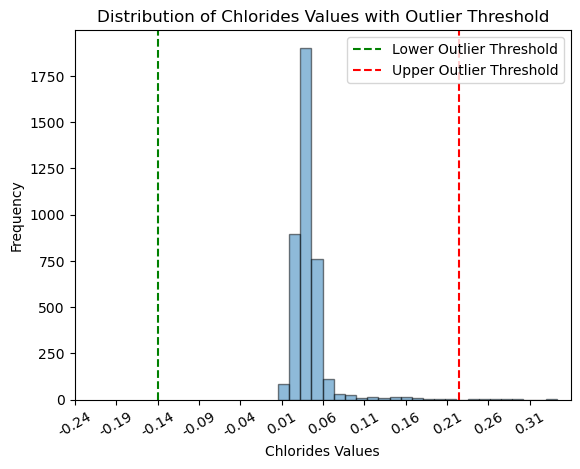

In [16]:
chlorides = df['chlorides']

#Calculate statistical measures for the column
mean_chlorides = np.mean(chlorides)
std_chlorides = np.std(chlorides)
print(f"Mean: {mean_chlorides:.3f}, Std. dev: {std_chlorides:.3f}")

#Define a threshold as a multiple of standard deviation (adjust as needed)
threshold = 8

#Identify outliers
outliers_chlorides = chlorides[(chlorides - mean_chlorides) > threshold * std_chlorides]
print(f'Outlier Values:\n{outliers_chlorides}')
print(f'No. of outliers: {len(outliers_chlorides)}')

#Plot the histogram of chlorides
axes = plt.axes()
plt.hist(chlorides, bins=25, edgecolor='black', alpha=0.5)
plt.xlabel('Chlorides Values')
plt.ylabel('Frequency')
xticks = np.arange(mean_chlorides - threshold * std_chlorides - 0.1, mean_chlorides + threshold * std_chlorides + 0.1, 0.05)
axes.set_xticks(xticks)
axes.set_xticklabels(xticks)
axes.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.2f}'))
axes.tick_params(axis='x', rotation=30)
plt.title('Distribution of Chlorides Values with Outlier Threshold')

#Add a line to indicate the threshold for outliers
plt.axvline(x=mean_chlorides - threshold * std_chlorides, color='green', linestyle='--', label='Lower Outlier Threshold')
plt.axvline(x=mean_chlorides + threshold * std_chlorides, color='red', linestyle='--', label='Upper Outlier Threshold')
plt.legend()

plt.show()

Mean: 34.909, Std. dev: 17.235
Outlier Values:
325     131.0
659     122.5
1931    146.5
2334    128.0
3050    138.5
3307    124.0
4745    289.0
Name: free sulfur dioxide, dtype: float64
No. of outliers: 7


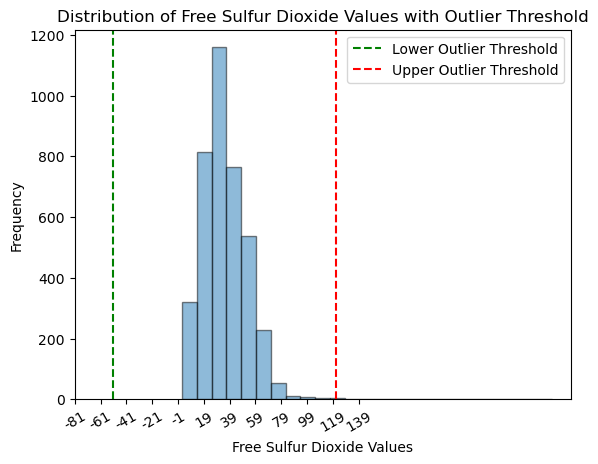

In [17]:
free_sulfur_dioxide = df['free sulfur dioxide']

#Calculate statistical measures for the column
mean_free_sulfur_dioxide = np.mean(free_sulfur_dioxide)
std_free_sulfur_dioxide = np.std(free_sulfur_dioxide)
print(f"Mean: {mean_free_sulfur_dioxide:.3f}, Std. dev: {std_free_sulfur_dioxide:.3f}")

#Define a threshold as a multiple of standard deviation (adjust as needed)
threshold = 5

#Identify outliers
outliers_free_sulfur_dioxide = free_sulfur_dioxide[(free_sulfur_dioxide - mean_free_sulfur_dioxide) > threshold * std_free_sulfur_dioxide]
print(f'Outlier Values:\n{outliers_free_sulfur_dioxide}')
print(f'No. of outliers: {len(outliers_free_sulfur_dioxide)}')

#Plot the histogram of free sulfur dioxide
axes = plt.axes()
plt.hist(free_sulfur_dioxide, bins=25, edgecolor='black', alpha=0.5)
plt.xlabel('Free Sulfur Dioxide Values')
plt.ylabel('Frequency')
xticks = np.arange(int(mean_free_sulfur_dioxide - threshold * std_free_sulfur_dioxide) - 30, int(mean_free_sulfur_dioxide + threshold * std_free_sulfur_dioxide) + 30, 20)
axes.set_xticks(xticks)
axes.set_xticklabels(xticks)
axes.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
axes.tick_params(axis='x', rotation=30)
plt.title('Distribution of Free Sulfur Dioxide Values with Outlier Threshold')

#Add a line to indicate the threshold for outliers
plt.axvline(x=mean_free_sulfur_dioxide - threshold * std_free_sulfur_dioxide, color='green', linestyle='--', label='Lower Outlier Threshold')
plt.axvline(x=mean_free_sulfur_dioxide + threshold * std_free_sulfur_dioxide, color='red', linestyle='--', label='Upper Outlier Threshold')
plt.legend()

plt.show()

Mean: 137.166, Std. dev: 43.073
Outlier Values:
1417    366.5
4745    440.0
Name: total sulfur dioxide, dtype: float64
No. of outliers: 2


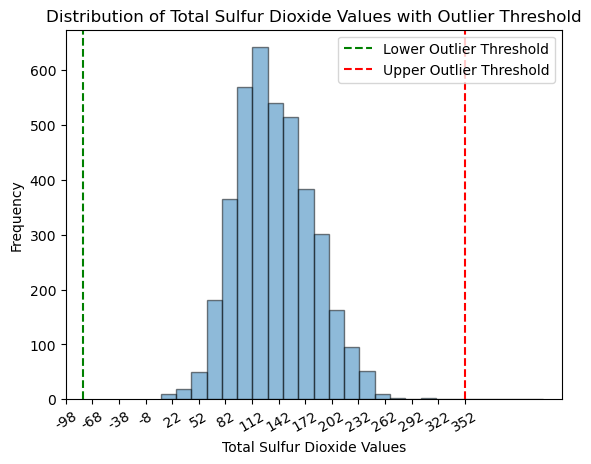

In [18]:
total_sulfur_dioxide = df['total sulfur dioxide']

#Calculate statistical measures for the column
mean_total_sulfur_dioxide = np.mean(total_sulfur_dioxide)
std_total_sulfur_dioxide = np.std(total_sulfur_dioxide)
print(f"Mean: {mean_total_sulfur_dioxide:.3f}, Std. dev: {std_total_sulfur_dioxide:.3f}")

#Define a threshold as a multiple of standard deviation (adjust as needed)
threshold = 5

#Identify outliers
outliers_total_sulfur_dioxide = total_sulfur_dioxide[(total_sulfur_dioxide - mean_total_sulfur_dioxide) > threshold * std_total_sulfur_dioxide]
print(f'Outlier Values:\n{outliers_total_sulfur_dioxide}')
print(f'No. of outliers: {len(outliers_total_sulfur_dioxide)}')

#Plot the histogram of total sulfur dioxide
axes = plt.axes()
plt.hist(total_sulfur_dioxide, bins=25, edgecolor='black', alpha=0.5)
plt.xlabel('Total Sulfur Dioxide Values')
plt.ylabel('Frequency')
xticks = np.arange(int(mean_total_sulfur_dioxide - threshold * std_total_sulfur_dioxide) - 20, int(mean_total_sulfur_dioxide + threshold * std_total_sulfur_dioxide) + 20, 30)
axes.set_xticks(xticks)
axes.set_xticklabels(xticks)
axes.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
axes.tick_params(axis='x', rotation=30)
plt.title('Distribution of Total Sulfur Dioxide Values with Outlier Threshold')

#Add a line to indicate the threshold for outliers
plt.axvline(x=mean_total_sulfur_dioxide - threshold * std_total_sulfur_dioxide, color='green', linestyle='--', label='Lower Outlier Threshold')
plt.axvline(x=mean_total_sulfur_dioxide + threshold * std_total_sulfur_dioxide, color='red', linestyle='--', label='Upper Outlier Threshold')
plt.legend()

plt.show()

Mean: 0.994, Std. dev: 0.003
Outlier Values:
1653    1.01030
2781    1.03898
Name: density, dtype: float64
No. of outliers: 2


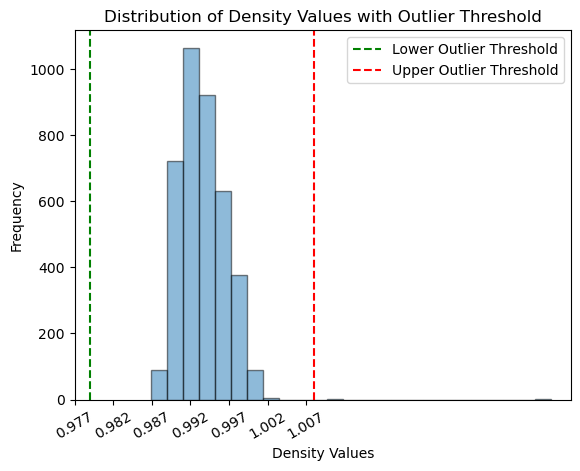

In [19]:
density = df['density']

#Calculate statistical measures for the column
mean_density = np.mean(density)
std_density = np.std(density)
print(f"Mean: {mean_density:.3f}, Std. dev: {std_density:.3f}")

#Define a threshold as a multiple of standard deviation (adjust as needed)
threshold = 5

#Identify outliers
outliers_density = density[(density - mean_density) > threshold * std_density]
print(f'Outlier Values:\n{outliers_density}')
print(f'No. of outliers: {len(outliers_density)}')

#Plot the histogram of density
axes = plt.axes()
plt.hist(density, bins=25, edgecolor='black', alpha=0.5)
plt.xlabel('Density Values')
plt.ylabel('Frequency')
xticks = np.arange(mean_density - threshold * std_density - 0.002, mean_density + threshold * std_density + 0.002, 0.005)
axes.set_xticks(xticks)
axes.set_xticklabels(xticks)
axes.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.3f}'))
axes.tick_params(axis='x', rotation=30)
plt.title('Distribution of Density Values with Outlier Threshold')

#Add a line to indicate the threshold for outliers
plt.axvline(x=mean_density - threshold * std_density, color='green', linestyle='--', label='Lower Outlier Threshold')
plt.axvline(x=mean_density + threshold * std_density, color='red', linestyle='--', label='Upper Outlier Threshold')
plt.legend()

plt.show()

Mean: 3.196, Std. dev: 0.152
Outlier Values:
Series([], Name: pH, dtype: float64)
No. of outliers: 0


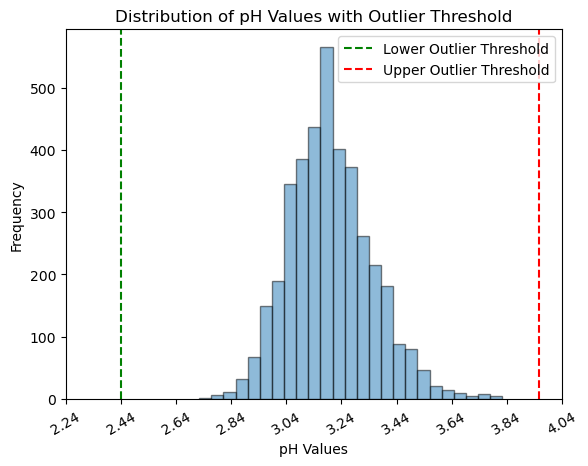

In [20]:
pH = df['pH']

#Calculate statistical measures for the column
mean_pH = np.mean(pH)
std_pH = np.std(pH)
print(f"Mean: {mean_pH:.3f}, Std. dev: {std_pH:.3f}")

#Define a threshold as a multiple of standard deviation (adjust as needed)
threshold = 5

#Identify outliers
outliers_pH = pH[(pH - mean_pH) > threshold * std_pH]
print(f'Outlier Values:\n{outliers_pH}')
print(f'No. of outliers: {len(outliers_pH)}')

#Plot the histogram of pH
axes = plt.axes()
plt.hist(pH, bins=25, edgecolor='black', alpha=0.5)
plt.xlabel('pH Values')
plt.ylabel('Frequency')
xticks = np.arange(mean_pH - threshold * std_pH - 0.2, mean_pH + threshold * std_pH + 0.2, 0.2)
axes.set_xticks(xticks)
axes.set_xticklabels(xticks)
axes.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.2f}'))
axes.tick_params(axis='x', rotation=30)
plt.title('Distribution of pH Values with Outlier Threshold')

#Add a line to indicate the threshold for outliers
plt.axvline(x=mean_pH - threshold * std_pH, color='green', linestyle='--', label='Lower Outlier Threshold')
plt.axvline(x=mean_pH + threshold * std_pH, color='red', linestyle='--', label='Upper Outlier Threshold')
plt.legend()

plt.show()

Mean: 0.491, Std. dev: 0.114
Outlier Values:
2441    1.06
4886    1.08
Name: sulphates, dtype: float64
No. of outliers: 2


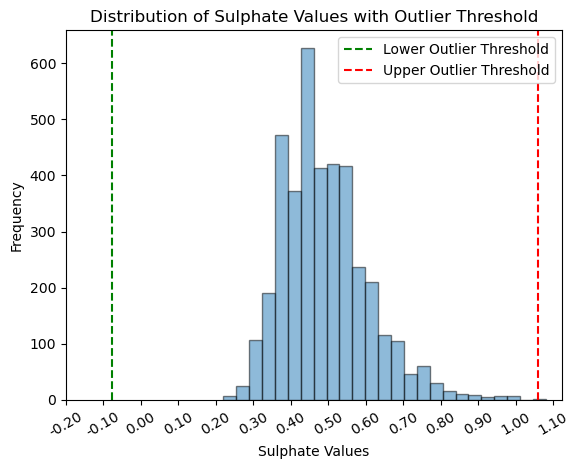

In [21]:
sulphates = df['sulphates']

# Calculate statistical measures for the column
mean_sulphates = np.mean(sulphates)
std_sulphates = np.std(sulphates)
print (f"Mean: {mean_sulphates:.3f}, Std. dev: {std_sulphates:.3f}")


# Define a threshold as a multiple of standard deviation (adjust as needed)
threshold = 5


# Identify outliers
outliers_sulphates = sulphates[(sulphates - mean_sulphates).abs() > threshold * std_sulphates]
print(f'Outlier Values:\n{outliers_sulphates}')
print(f'No. of outliers: {len(outliers_sulphates)}')



# Plot the histogram of sulphates
axes = plt.axes()
plt.hist(sulphates, bins=25, edgecolor='black', alpha=0.5)
plt.xlabel('Sulphate Values')
plt.ylabel('Frequency')
xticks = np.arange(int((mean_sulphates)-threshold*std_sulphates) - 0.2, int(mean_sulphates+threshold*std_sulphates)+0.2, 0.1)
axes.set_xticks(xticks)
axes.set_xticklabels(xticks)
axes.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.2f}'))
axes.tick_params(axis='x', rotation=30)
plt.title('Distribution of Sulphate Values with Outlier Threshold')


# Add a line to indicate the threshold for outliers
plt.axvline(x=mean_sulphates-threshold*std_sulphates, color='green', linestyle='--', label='Lower Outlier Threshold')
plt.axvline(x=mean_sulphates+threshold*std_sulphates, color='red', linestyle='--', label='Upper Outlier Threshold')
plt.legend()


plt.show()


Mean: 10.592, Std. dev: 1.217
Outlier Values:
Series([], Name: alcohol, dtype: float64)
No. of outliers: 0


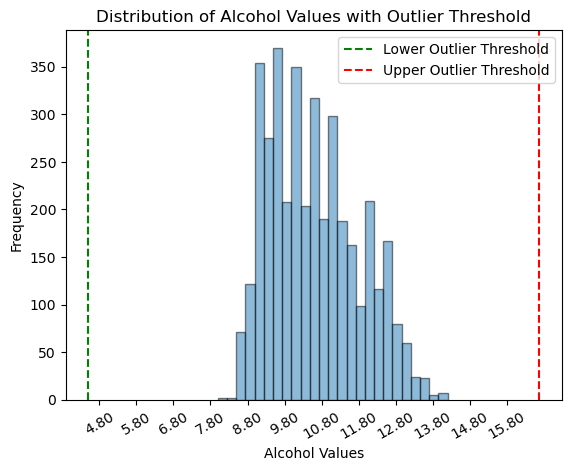

In [22]:
alcohol = df['alcohol']

#Calculate statistical measures for the column
mean_alcohol = np.mean(alcohol)
std_alcohol = np.std(alcohol)
print(f"Mean: {mean_alcohol:.3f}, Std. dev: {std_alcohol:.3f}")

#Define a threshold as a multiple of standard deviation (adjust as needed)
threshold = 5

#Identify outliers
outliers_alcohol = alcohol[(alcohol - mean_alcohol) > threshold * std_alcohol]
print(f'Outlier Values:\n{outliers_alcohol}')
print(f'No. of outliers: {len(outliers_alcohol)}')

#Plot the histogram of alcohol
axes = plt.axes()
plt.hist(alcohol, bins=25, edgecolor='black', alpha=0.5)
plt.xlabel('Alcohol Values')
plt.ylabel('Frequency')
xticks = np.arange(int(mean_alcohol - threshold * std_alcohol) - 0.2, int(mean_alcohol + threshold * std_alcohol) + 0.2, 1)
axes.set_xticks(xticks)
axes.set_xticklabels(xticks)
axes.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.2f}'))
axes.tick_params(axis='x', rotation=30)
plt.title('Distribution of Alcohol Values with Outlier Threshold')

#Add a line to indicate the threshold for outliers
plt.axvline(x=mean_alcohol - threshold * std_alcohol, color='green', linestyle='--', label='Lower Outlier Threshold')
plt.axvline(x=mean_alcohol + threshold * std_alcohol, color='red', linestyle='--', label='Upper Outlier Threshold')
plt.legend()

plt.show()

In [23]:
print("Summary of outliers:")

print(f'No. of fixed acidity outliers: {len(outliers_fixed_acidity)}')
print(f'No. of volatile acidity outliers: {len(outliers_volatile_acidity)}')
print(f'No. of citric acid outliers: {len(outliers_citric_acid)}')
print(f'No. of residual sugar outliers: {len(outliers_residual_sugar)}')
print(f'No. of chlorides outliers: {len(outliers_chlorides)}')
print(f'No. of free sulfur dioxide outliers: {len(outliers_free_sulfur_dioxide)}')
print(f'No. of total sulfur dioxide outliers: {len(outliers_total_sulfur_dioxide)}')
print(f'No. of density outliers: {len(outliers_density)}')
print(f'No. of pH outliers: {len(outliers_pH)}')
print(f'No. of sulphates outliers: {len(outliers_sulphates)}')
print(f'No. of alcohol outliers: {len(outliers_alcohol)}')


Summary of outliers:
No. of fixed acidity outliers: 2
No. of volatile acidity outliers: 8
No. of citric acid outliers: 8
No. of residual sugar outliers: 2
No. of chlorides outliers: 8
No. of free sulfur dioxide outliers: 7
No. of total sulfur dioxide outliers: 2
No. of density outliers: 2
No. of pH outliers: 0
No. of sulphates outliers: 2
No. of alcohol outliers: 0


In [24]:
#Removing entire rows which contain outliers

# Combine outlier Series into a single list
outliers_list = [outliers_fixed_acidity, outliers_sulphates, outliers_volatile_acidity, 
                 outliers_citric_acid, outliers_residual_sugar, outliers_chlorides, outliers_free_sulfur_dioxide,
                outliers_total_sulfur_dioxide, outliers_density, outliers_pH, outliers_alcohol]



# Concatenate outlier Series into a single DataFrame
outliers_df = pd.concat(outliers_list)
print(f"Total number of outliers: {len(outliers_df)}")


# Remove rows with outliers from the original DataFrame
clean_data = df.drop(outliers_df.index)
clean_rows, clean_columns = clean_data.shape
print(f"Rows in clean data = {clean_rows}")
print(f"Columns in clean data = {clean_columns}")


Total number of outliers: 41
Rows in clean data = 3866
Columns in clean data = 13


## Model Building: Feature Selection

Now that we have the clean data, we can start to build a model that can classify new wine samples as 'good' or 'bad'.

To do that, we need to select the features which we will use for model building. Eliminating less relevant features from the model improves simplicity, interpretability, and reduces overfitting. It also helps identify the subset of features that are most informative and contribute the most to the model's predictive power.

We need to determine which variables affect the quality/class of wine. This can be done using a statistical test such as an independent samples t-test. The t-test compares the means of two groups (class 0 and class 1) and determines if the difference in means ( mean values of the continuous predictor variable between the two groups defined by the class 0 and class 1) is statistically significant.  

We can formulate our hypotheses in the following way-

$H_0$ : the variable is not significant, i.e., the presence of that variable doesn't have significant effect on the wine.

$H_a$ : the variable is significant, i.e., the presence of that variable has significant effect on the wine.

The p-value indicates the probability of observing such a difference by chance. If the p-value is below a chosen significance level (e.g., 0.05), we can reject the null hypothesis and conclude that the presence of that variable has a significant effect on the wine class.


In [25]:
#extracting names of all predictors
predictors = list(clean_data.columns)
predictors.remove('quality')
predictors.remove('class')
print(predictors)

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


In [26]:
#looping through the list of predictors and performing t-test

selected_variables = []

for predictor in predictors:
    column = clean_data[predictor]
    target = clean_data['class']


    # Split the predictor into two groups based on the target variable
    group_0 = column[target == 0]
    group_1 = column[target == 1]

    print(f"VARIABLE - {predictor}")
    print("\nMean of class 0: ", statistics.mean(group_0), "\nMean of class 1: ", statistics.mean(group_1))

    # Perform t-test
    t_stat, p_value = ttest_ind(group_0, group_1)

    print("T-statistic:", t_stat)
    print("P-value:", p_value)

    if p_value < 0.05:
        result = f"\nReject H0. The variable {predictor} has significant effect on the wine."
        selected_variables.append(predictor)
    else:
        result = f"\nAccept H0. The variable {predictor} doesn't have significant effect on the wine."

    print(result)
    print("---------------------------")
    
print(f"\nOur {len(selected_variables)} final selected variables are {selected_variables}")

VARIABLE - fixed acidity

Mean of class 0:  6.938246554364472 
Mean of class 1:  6.774609375
T-statistic: 5.671201522905876
P-value: 1.5218015115555327e-08

Reject H0. The variable fixed acidity has significant effect on the wine.
---------------------------
VARIABLE - volatile acidity

Mean of class 0:  0.3078905053598775 
Mean of class 1:  0.263796875
T-statistic: 13.467399328268709
P-value: 1.9607669652858015e-40

Reject H0. The variable volatile acidity has significant effect on the wine.
---------------------------
VARIABLE - citric acid

Mean of class 0:  0.33179938744257276 
Mean of class 1:  0.33256640625
T-statistic: -0.19347022428313146
P-value: 0.8466008919712334

Accept H0. The variable citric acid doesn't have significant effect on the wine.
---------------------------
VARIABLE - residual sugar

Mean of class 0:  6.6344946401225116 
Mean of class 1:  5.48552734375
T-statistic: 7.192184292847461
P-value: 7.619944639001543e-13

Reject H0. The variable residual sugar has sign

## Model Building: Fitting a Model

We are going to fit a logistic regression model to our data, and get the estimated coefficients. Using this, we will be able to predict wine quality for a new set of variables.

$ P(y=1 \mid \mathbf{X}) = sigmoid ( X\beta ) $

$ P(y=1 \mid \mathbf{X}) = \Large \frac{1}{1 + e^{-(\beta_0  +  \beta_1 x_1  +  \beta_2 x_2  +  \ldots  +  \beta_p x_p)}} $


In [27]:
X_train = clean_data[selected_variables]
X_train.head(10)

,fixed acidity,volatile acidity,residual sugar,chlorides,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.0,0.27,20.70,0.045,170.0,1.0010,3.00,0.45,8.8
1,6.3,0.30,1.60,0.049,132.0,0.9940,3.30,0.49,9.5
2,8.1,0.28,6.90,0.050,97.0,0.9951,3.26,0.44,10.1
3,7.2,0.23,8.50,0.058,186.0,0.9956,3.19,0.40,9.9
6,6.2,0.32,7.00,0.045,136.0,0.9949,3.18,0.47,9.6
9,8.1,0.22,1.50,0.044,129.0,0.9938,3.22,0.45,11.0
10,8.1,0.27,1.45,0.033,63.0,0.9908,2.99,0.56,12.0
11,8.6,0.23,4.20,0.035,109.0,0.9947,3.14,0.53,9.7
12,7.9,0.18,1.20,0.040,75.0,0.9920,3.18,0.63,10.8
13,6.6,0.16,1.50,0.044,143.0,0.9912,3.54,0.52,12.4


In [28]:
y_train = clean_data['class']
y_train.head(10)

0     1
1     1
2     1
3     1
6     1
9     1
10    0
11    0
12    0
13    1
Name: class, dtype: int64

In [29]:
# Create an instance of the LogisticRegression model
logreg = LogisticRegression(max_iter=1000)

# Fit the model to data
model = logreg.fit(X_train, y_train)

# Get the coefficients
coefficients = model.coef_
intercept = model.intercept_

# Create a DataFrame to display the coefficients
coefficients_df = pd.DataFrame({'Feature': ['Intercept'] + selected_variables, 
                                'Coefficient': np.concatenate([intercept, coefficients[0]])})

# Print the coefficients
print(coefficients_df)

                Feature  Coefficient
0             Intercept    -9.954982
1         fixed acidity    -0.174834
2      volatile acidity    -5.443793
3        residual sugar     0.053905
4             chlorides     0.138298
5  total sulfur dioxide     0.001880
6               density    -0.158591
7                    pH     0.461592
8             sulphates     1.234719
9               alcohol     1.043543


These coefficients are denoted by $ \beta_0  ,  \beta_1 ,  \beta_2 ,  \ldots   \beta_9 $

The values of the predictors in the dataset are denoted by $x_0, x_1, x_2, \ldots x_9 $

where $x_0 = 1 $ because it is related to the intercept.

### Drawing insights

The coefficients of “fixed acidity”, "density" and “volatile acidity” are negative (< 0), hence, increase in value of any of these variables while keeping other variables fixed will decrease the chances of the wine being GOOD.

The coefficients of the rest of the variables are positive (> 0), hence, increase in value of any of these variables while keeping other variables fixed will increase chances of the wine being GOOD.


If we assume all explanatory variables to have value 0 (i.e., the drink has no sulphates, no sulfur dioxide, no residual sugar, no alcohol, etc) then the probability of wine being Good is sigmoid($β_0$) = 0.0000474882. 

Thus, it highly likely that is a Bad wine. In fact, we can’t even call that commodity a wine, to begin with!


In [30]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

prob = sigmoid(intercept)[0]

print(f"{prob:.10f}")

0.0000474882


## Evaluating the Model Performance

We can now use this model to predict the class values on the training and test data. Then we can calculate both training and test MSE to see how well it is performing.

In [31]:
# Make predictions on the training data
y_train_pred = model.predict(X_train)

# Calculate squared differences
squared_diff_train = (y_train - y_train_pred) ** 2

# Calculate the mean squared error
training_mse = np.mean(squared_diff_train)

print(f"Training MSE: {training_mse}")

Training MSE: 0.25426797723745476


Again, converting the 'quality' into a binary categorical variable for the test set using the mean 5.85. Any wine with a quality score lower than or equal to 5 can be categorized as class 0 or 'bad' wine; and any wine with quality score higher than 5 can be categorized as class 1 or 'good' wine. We add another column to the test dataframe called 'class' and store the correct class in it.

In [32]:
wine_class_test = []
quality_test = test_set['quality']
for q in quality_test:
    if q>mean_value:
        wine_class_test.append(1)
    else:
        wine_class_test.append(0)

test_set.loc[:, 'class'] = wine_class_test
test_set


/var/folders/61/5gjx4xb906zf4wq9cntygmr80000gn/T/ipykernel_68306/1136362343.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set.loc[:, 'class'] = wine_class_test


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,class
4656,6.0,0.29,0.41,10.8,0.048,55.0,149.0,0.99370,3.09,0.59,10.966667,7,1
3659,5.4,0.53,0.16,2.7,0.036,34.0,128.0,0.98856,3.20,0.53,13.200000,8,1
907,7.1,0.25,0.39,2.1,0.036,30.0,124.0,0.99080,3.28,0.43,12.200000,8,1
4352,7.3,0.28,0.35,1.6,0.054,31.0,148.0,0.99178,3.18,0.47,10.700000,5,0
3271,6.5,0.32,0.34,5.7,0.044,27.0,91.0,0.99184,3.28,0.60,12.000000,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,7.3,0.25,0.41,1.8,0.037,52.0,165.0,0.99110,3.29,0.39,12.200000,7,1
3513,7.9,0.35,0.28,12.9,0.032,13.0,63.0,0.99320,2.99,0.43,13.000000,6,1
3771,6.1,0.27,0.28,9.8,0.042,61.0,125.0,0.99532,3.14,0.42,10.200000,6,1
2440,6.8,0.46,0.26,6.3,0.147,49.0,159.0,0.99434,3.14,0.47,10.000000,5,0


In [33]:
# Predicting values in the test data, using the selected variables only
X_test = test_set[selected_variables]

y_test = test_set['class']

y_test_pred = model.predict(X_test)

squared_diff_test = (y_test_pred - y_test) ** 2

test_mse = np.mean(squared_diff_test)

print(f"Test MSE: {test_mse}")



Test MSE: 0.28


Now we can plot a confusion matrix to see how our model performed on the test set-

In [34]:
counts = np.bincount(y_test)
count_zeros = counts[0]  # Number of zeros
count_ones = counts[1]  # Number of ones

print("Number of actual bad wines:", count_zeros)
print("Number of actual good wines:", count_ones)

counts_pred = np.bincount(y_test_pred)
count_zeros_pred = counts_pred[0]  # Number of zeros
count_ones_pred = counts_pred[1]  # Number of ones

print("Number of predicted bad wines:", count_zeros_pred)
print("Number of predcited good wines:", count_ones_pred)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

actual_class_labels = ['Bad (actual)', 'Good (actual)']
predicted_class_labels = ['Bad (predicted)','Good (predicted)']

cm_df = pd.DataFrame(cm, index=actual_class_labels, columns=predicted_class_labels)


print("\nConfusion Matrix:")
print(cm_df)

Number of actual bad wines: 34
Number of actual good wines: 66
Number of predicted bad wines: 30
Number of predcited good wines: 70

Confusion Matrix:
               Bad (predicted)  Good (predicted)
Bad (actual)                18                16
Good (actual)               12                54


In [35]:
# Assuming you have predicted values and actual values


# Calculate the error rate
error_count = 0  # Initialize a counter for error count

# Loop through each predicted value and actual value
for predicted, actual in zip(y_test_pred, y_test):
    if predicted != actual:  # Check if the predicted value is different from the actual value
        error_count += 1  # If they are different, increment the error count

# Calculate the error rate by dividing the error count by the total number of predictions
error_rate = error_count / len(y_test_pred)

# Print the error rate
print("Error Rate:", error_rate)

Error Rate: 0.28


We've got a small error rate, which shows that our model performs decently.

---END OF FILE---